# PROJECT - 3 - Application of Classification Models
## By Prakash Ghosh
---

### Problem Statement 

This data was extracted from the census bureau database found at http://www.census.gov/ftp/pub/DES/www/welcome.html

Donor: Ronny Kohavi and Barry Becker,<br>
Data Mining and Visualization<br>
Silicon Graphics.<br>
e-mail: ronnyk@sgi.com for questions.<br>


Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).<br>
* 48842 instances, mix of continuous and discrete (train=32561, test=16281)<br>
* 45222 if instances with unknown values are removed (train=30162, test=15060)<br>
* Duplicate or conflicting instances : 6<br>
* Class probabilities for adult.all file<br>
* Probability for the label '>50K' : 23.93% / 24.78% (without unknowns)<br>
* Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)<br>

Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions:
((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0)) Prediction task is to determine whether a person makes over 50K a year. Conversion of original data as follows:

1. Discretized a gross income into two ranges with threshold 50,000.<br>
2. Convert U.S. to US to avoid periods.<br>
3. Convert Unknown to "?"<br>
4. Run MLC++ GenCVFiles to generate data,test.<br>

Description of fnlwgt (final weight)
The weights on the CPS files are controlled to independent estimates of the civilian noninstitutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

1. A single cell estimate of the population 16+ for each state.<br>
2. Controls for Hispanic Origin by age and sex.<br>
3. Controls by Race, age and sex.<br>

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. 

The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

Dataset Link
https://archive.ics.uci.edu/ml/machine-learning-databases/adult/

---
#### Problem 1: Prediction task is to determine whether a person makes over 50K a year.
---
#### Problem 2: Which factors are important
---
#### Problem 3: Which algorithms are best for this dataset
---

### Solution:

In [1]:
# Import Required Libraries
import numpy as np 
import pandas as pd

from sklearn import tree, metrics, datasets
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier

import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.5)

#### Load Data

In [145]:
# Load data from link
train_URL="https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_URL= "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
       
train_set = pd.read_csv(train_URL, header = None)
test_set = pd.read_csv(test_URL, header = None, skiprows = 1)

# Column Names for the Datasets
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation',
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 
              'wage_class'] 

# Assign Column Names
train_set.columns = col_labels 
test_set.columns = col_labels

In [146]:
train_set.head(5)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [147]:
test_set.head(5)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


#### Analyze Data

In [148]:
# train_set information
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
wage_class        32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [149]:
# test_set information
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workclass         16281 non-null object
fnlwgt            16281 non-null int64
education         16281 non-null object
education_num     16281 non-null int64
marital_status    16281 non-null object
occupation        16281 non-null object
relationship      16281 non-null object
race              16281 non-null object
sex               16281 non-null object
capital_gain      16281 non-null int64
capital_loss      16281 non-null int64
hours_per_week    16281 non-null int64
native_country    16281 non-null object
wage_class        16281 non-null object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


In [150]:
#Describe train_set
train_set.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [151]:
#Describe test_set
test_set.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,16281.000000,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000
mean,38.767459,1.894357e+05,10.072907,1081.905104,87.899269,40.392236
std,13.849187,1.057149e+05,2.567545,7583.935968,403.105286,12.479332
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.167360e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.778310e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.383840e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


In [152]:
# Group the Data with respect to count of wage_class in train_set
train_set.groupby('wage_class').count()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
wage_class,,,,,,,,,,,,,,
<=50K,24720,24720,24720,24720,24720,24720,24720,24720,24720,24720,24720,24720,24720,24720
>50K,7841,7841,7841,7841,7841,7841,7841,7841,7841,7841,7841,7841,7841,7841


In [153]:
# Group the Data with respect to count of wage_class in test_set
test_set.groupby('wage_class').count()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
wage_class,,,,,,,,,,,,,,
<=50K.,12435,12435,12435,12435,12435,12435,12435,12435,12435,12435,12435,12435,12435,12435
>50K.,3846,3846,3846,3846,3846,3846,3846,3846,3846,3846,3846,3846,3846,3846


##### As our target variable is wage class, will visualize the categorical variable w.r.t. wage class

Text(0,0.5,'Wage Class')

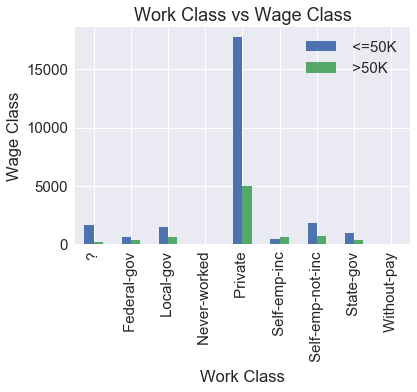

In [154]:
# barplot of Work Class vs Wage Class
pd.crosstab(train_set['workclass'], train_set['wage_class'].astype(object)).plot(kind='bar')
plt.title('Work Class vs Wage Class')
plt.legend()
plt.xlabel('Work Class')
plt.ylabel('Wage Class')

Text(0,0.5,'Wage Class')

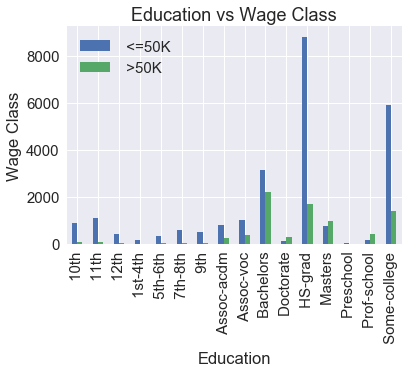

In [155]:
# barplot of Education vs Wage Class
pd.crosstab(train_set['education'], train_set['wage_class'].astype(object)).plot(kind='bar')
plt.title('Education vs Wage Class')
plt.legend()
plt.xlabel('Education')
plt.ylabel('Wage Class')

Text(0,0.5,'Wage Class')

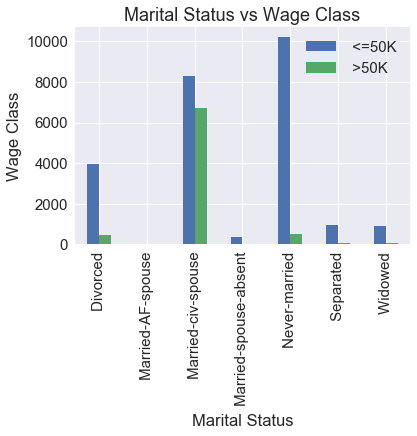

In [156]:
# barplot of Marital Status vs Wage Class
pd.crosstab(train_set['marital_status'], train_set['wage_class'].astype(object)).plot(kind='bar')
plt.title('Marital Status vs Wage Class')
plt.legend()
plt.xlabel('Marital Status')
plt.ylabel('Wage Class')

Text(0,0.5,'Wage Class')

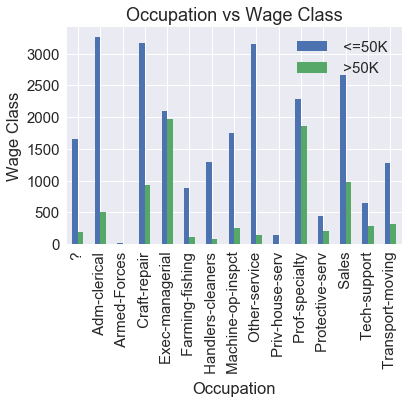

In [157]:
# barplot of Occupation vs Wage Class
pd.crosstab(train_set['occupation'], train_set['wage_class'].astype(object)).plot(kind='bar')
plt.title('Occupation vs Wage Class')
plt.legend()
plt.xlabel('Occupation')
plt.ylabel('Wage Class')

Text(0,0.5,'Wage Class')

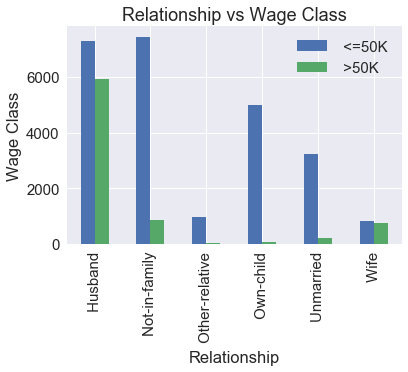

In [158]:
# barplot of Relationship vs Wage Class
pd.crosstab(train_set['relationship'], train_set['wage_class'].astype(object)).plot(kind='bar')
plt.title('Relationship vs Wage Class')
plt.legend()
plt.xlabel('Relationship')
plt.ylabel('Wage Class')

Text(0,0.5,'Wage Class')

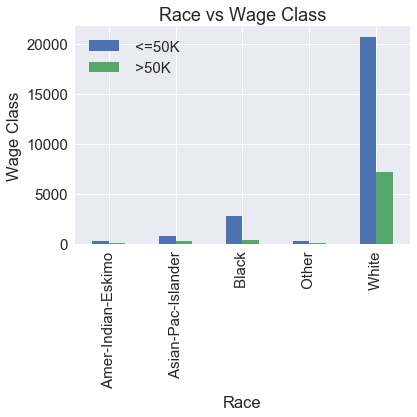

In [159]:
# barplot of Race vs Wage Class
pd.crosstab(train_set['race'], train_set['wage_class'].astype(object)).plot(kind='bar')
plt.title('Race vs Wage Class')
plt.legend()
plt.xlabel('Race')
plt.ylabel('Wage Class')

Text(0,0.5,'Wage Class')

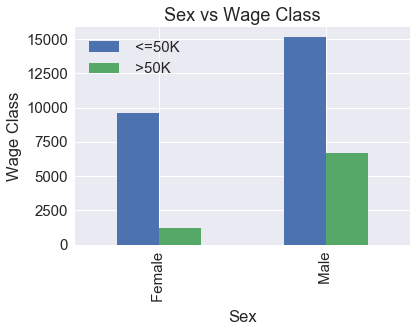

In [160]:
# barplot of Sex vs Wage Class
pd.crosstab(train_set['sex'], train_set['wage_class'].astype(object)).plot(kind='bar')
plt.title('Sex vs Wage Class')
plt.legend()
plt.xlabel('Sex')
plt.ylabel('Wage Class')

#### Prepare Data for the Model
* Clean Data
* Convert Categorical Variable to Numerical Variable

In [161]:
# Clean Train Dataset
train_set['wage_class'] =train_set.wage_class.replace({' <=50K': '<=50K', ' >50K':'>50K'})
train_set = train_set.replace(' ?', np.nan).dropna()
train_set.shape

(30162, 15)

In [162]:
# Clean Test Dataset
test_set['wage_class'] =test_set.wage_class.replace({' <=50K': '<=50K', ' >50K':'>50K'})
test_set = test_set.replace(' ?', np.nan).dropna()
test_set.shape

(15060, 15)

In [163]:
# Convert Categorical Variable to Numerical Variable for Train Dataset
for feature in train_set.columns: 
    if train_set[feature].dtype == 'object': 
        train_set[feature] = pd.Categorical(train_set[feature]).codes 

train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 15 columns):
age               30162 non-null int64
workclass         30162 non-null int8
fnlwgt            30162 non-null int64
education         30162 non-null int8
education_num     30162 non-null int64
marital_status    30162 non-null int8
occupation        30162 non-null int8
relationship      30162 non-null int8
race              30162 non-null int8
sex               30162 non-null int8
capital_gain      30162 non-null int64
capital_loss      30162 non-null int64
hours_per_week    30162 non-null int64
native_country    30162 non-null int8
wage_class        30162 non-null int8
dtypes: int64(6), int8(9)
memory usage: 1.9 MB


In [164]:
# Convert Categorical Variable to Numerical Variable for Test Dataset
for feature in test_set.columns: 
    if test_set[feature].dtype == 'object': 
        test_set[feature] = pd.Categorical(test_set[feature]).codes 

test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15060 entries, 0 to 16280
Data columns (total 15 columns):
age               15060 non-null int64
workclass         15060 non-null int8
fnlwgt            15060 non-null int64
education         15060 non-null int8
education_num     15060 non-null int64
marital_status    15060 non-null int8
occupation        15060 non-null int8
relationship      15060 non-null int8
race              15060 non-null int8
sex               15060 non-null int8
capital_gain      15060 non-null int64
capital_loss      15060 non-null int64
hours_per_week    15060 non-null int64
native_country    15060 non-null int8
wage_class        15060 non-null int8
dtypes: int64(6), int8(9)
memory usage: 956.0 KB


In [165]:
train_set.describe()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
count,30162.000000,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,2.199324,1.897938e+05,10.333764,10.121312,2.580134,5.959850,1.418341,3.678602,0.675685,1092.007858,88.372489,40.931238,36.382567,0.248922
std,13.134665,0.953925,1.056530e+05,3.812292,2.549995,1.498016,4.029566,1.601338,0.834709,0.468126,7406.346497,404.298370,11.979984,6.105372,0.432396
min,17.000000,0.000000,1.376900e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,28.000000,2.000000,1.176272e+05,9.000000,9.000000,2.000000,2.000000,0.000000,4.000000,0.000000,0.000000,0.000000,40.000000,38.000000,0.000000
50%,37.000000,2.000000,1.784250e+05,11.000000,10.000000,2.000000,6.000000,1.000000,4.000000,1.000000,0.000000,0.000000,40.000000,38.000000,0.000000
75%,47.000000,2.000000,2.376285e+05,12.000000,13.000000,4.000000,9.000000,3.000000,4.000000,1.000000,0.000000,0.000000,45.000000,38.000000,0.000000
max,90.000000,6.000000,1.484705e+06,15.000000,16.000000,6.000000,13.000000,5.000000,4.000000,1.000000,99999.000000,4356.000000,99.000000,40.000000,1.000000


In [166]:
test_set.describe()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
count,15060.000000,15060.000000,1.506000e+04,15060.000000,15060.000000,15060.000000,15060.000000,15060.000000,15060.000000,15060.000000,15060.000000,15060.000000,15060.000000,15060.000000,15060.000000
mean,38.768327,2.214874,1.896164e+05,10.272377,10.112749,2.595286,5.989044,1.401394,3.683665,0.673772,1120.301594,89.041899,40.951594,35.467596,0.245684
std,13.380676,0.966422,1.056150e+05,3.826251,2.558727,1.505336,4.020113,1.588954,0.827630,0.468848,7703.181842,406.283245,12.062831,5.880922,0.430506
min,17.000000,0.000000,1.349200e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,28.000000,2.000000,1.166550e+05,9.000000,9.000000,2.000000,2.000000,0.000000,4.000000,0.000000,0.000000,0.000000,40.000000,37.000000,0.000000
50%,37.000000,2.000000,1.779550e+05,11.000000,10.000000,2.000000,6.000000,1.000000,4.000000,1.000000,0.000000,0.000000,40.000000,37.000000,0.000000
75%,48.000000,2.000000,2.385888e+05,12.000000,13.000000,4.000000,9.000000,3.000000,4.000000,1.000000,0.000000,0.000000,45.000000,37.000000,0.000000
max,90.000000,6.000000,1.490400e+06,15.000000,16.000000,6.000000,13.000000,5.000000,4.000000,1.000000,99999.000000,3770.000000,99.000000,39.000000,1.000000


#### Feature Selection

In [167]:
# Train and Test dataset - Feature selection
y_train_feature = train_set.pop('wage_class')
x_train_feature=train_set

y_test_feature = test_set.pop('wage_class')
x_test_feature=test_set

In [168]:
# Fit the RandomForest model using train data 
rndforest = RandomForestClassifier(n_estimators=150)
rndforest.fit(x_train_feature, y_train_feature)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

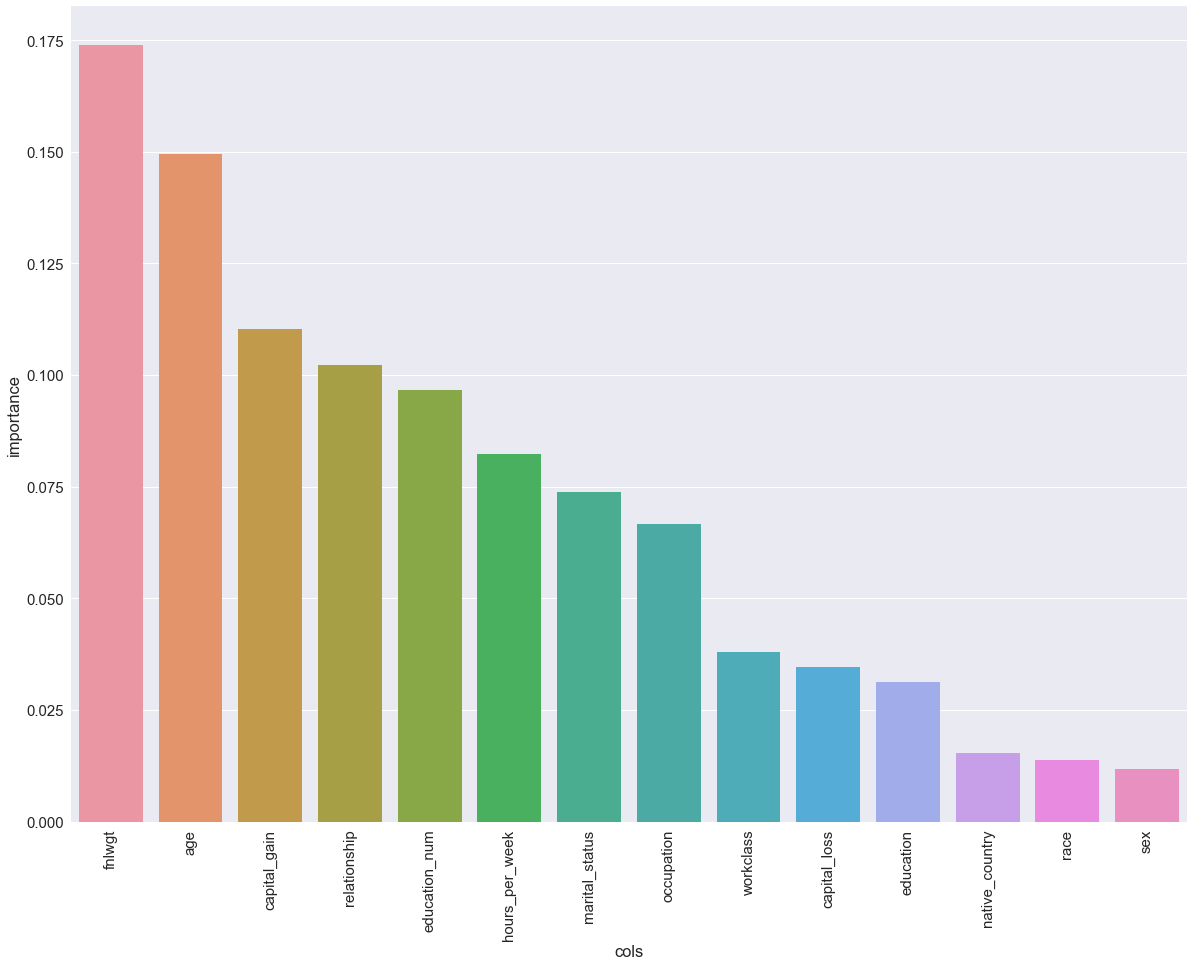

In [169]:
# Identify Feature Improtance using plot
feature_imp = pd.DataFrame.from_dict({'cols':x_train_feature.columns, 'importance': rndforest.feature_importances_})
feature_imp = feature_imp.sort_values(by='importance', ascending=False)
plt.figure(figsize=(20,15))
sns.barplot(feature_imp.cols, feature_imp.importance)
plt.xticks(rotation=90)

In [170]:
# Choose Features having higher importances i.e. >0.05
imp_feature_cols = feature_imp[feature_imp.importance > 0.05].cols.values
imp_feature_cols

array(['fnlwgt', 'age', 'capital_gain', 'relationship', 'education_num',
       'hours_per_week', 'marital_status', 'occupation'], dtype=object)

#### Model Selection

In [171]:
model_name = ["Decision Tree", "Random Forest", "AdaBoost", "Logisic", "GBM","xgboost"]

xgb_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 
              'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}

classifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier(n_estimators=100),
    LogisticRegression(),
    GradientBoostingClassifier(n_estimators=100),
    xgb.XGBClassifier(**xgb_params)]

In [172]:
# Calculate the Accracy of each Model for ALL Cols 
for clf in zip(model_name, classifiers):
    clf[1].fit(x_train_feature, y_train_feature)
    print(clf[0], clf[1].score(x_test_feature, y_test_feature))

Decision Tree 0.8416334661354582
Random Forest 0.850265604249668
AdaBoost 0.8594289508632138
Logisic 0.7847941567065073
GBM 0.8629482071713147
xgboost 0.8679946879150067


C:\Users\praka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [173]:
# Calculate the Accracy of each Model for Important Cols 
for clf in zip(model_name, classifiers):
    clf[1].fit(x_train_feature[imp_feature_cols], y_train_feature)
    print(clf[0], clf[1].score(x_test_feature[imp_feature_cols], y_test_feature))      

Decision Tree 0.8422310756972111
Random Forest 0.8377158034528552
AdaBoost 0.849003984063745
Logisic 0.7885126162018592
GBM 0.8551128818061089
xgboost 0.8569721115537848


C:\Users\praka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [175]:
# Confusion Matrix and Classfication Report for each Model
print('-'*60)
for clf in zip(model_name, classifiers):
    print(clf[0])
    pred = clf[1].predict(x_test_feature[imp_feature_cols])
    print(confusion_matrix(y_test_feature,pred))
    print(classification_report(y_test_feature,pred)) 
    print('-'*60)

------------------------------------------------------------
Decision Tree
[[10824   536]
 [ 1840  1860]]
             precision    recall  f1-score   support

          0       0.85      0.95      0.90     11360
          1       0.78      0.50      0.61      3700

avg / total       0.84      0.84      0.83     15060

------------------------------------------------------------
Random Forest
[[10396   964]
 [ 1480  2220]]
             precision    recall  f1-score   support

          0       0.88      0.92      0.89     11360
          1       0.70      0.60      0.64      3700

avg / total       0.83      0.84      0.83     15060

------------------------------------------------------------
AdaBoost
[[10541   819]
 [ 1455  2245]]
             precision    recall  f1-score   support

          0       0.88      0.93      0.90     11360
          1       0.73      0.61      0.66      3700

avg / total       0.84      0.85      0.84     15060

------------------------------------------

C:\Users\praka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Build and Evaluate the Model 
* XGBOOST

In [176]:
x_train_feature =x_train_feature[imp_feature_cols]
x_test_feature =x_test_feature[imp_feature_cols]

###### 5-Fold cross validation 

In [178]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 
              'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}

optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                            scoring = 'accuracy', 
                             cv = 5, n_jobs = -1) 
optimized_GBM.fit(x_train_feature, y_train_feature)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [179]:
print('Score :',optimized_GBM.best_score_)
print('Classes :',optimized_GBM.classes_)
print('Error Score :',optimized_GBM.error_score)
print('CV :',optimized_GBM.cv)
print('Probabalities :',optimized_GBM.predict_proba(x_train_feature))

Score : 0.8559114117100988
Classes : [0 1]
Error Score : raise
CV : 5
Probabalities : [[9.9785221e-01 2.1478157e-03]
 [7.5445414e-01 2.4554583e-01]
 [9.8262197e-01 1.7378034e-02]
 ...
 [9.6927589e-01 3.0724123e-02]
 [9.9981350e-01 1.8649657e-04]
 [5.8448315e-04 9.9941552e-01]]


In [180]:
# optimization
cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1}


optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1)
optimized_GBM.fit(x_train_feature, y_train_feature)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01], 'subsample': [0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [181]:
print('Score :',optimized_GBM.best_score_)
print('Classes :',optimized_GBM.classes_)
print('Error Score :',optimized_GBM.error_score)
print('CV :',optimized_GBM.cv)
print('Probabalities :',optimized_GBM.predict_proba(x_train_feature))

Score : 0.8559114117100988
Classes : [0 1]
Error Score : raise
CV : 5
Probabalities : [[9.9785221e-01 2.1478157e-03]
 [7.5445414e-01 2.4554583e-01]
 [9.8262197e-01 1.7378034e-02]
 ...
 [9.6927589e-01 3.0724123e-02]
 [9.9981350e-01 1.8649657e-04]
 [5.8448315e-04 9.9941552e-01]]


#### Improve the Model 

In [182]:
# Create DMatrix to make XGBoost more efficient
xgdmatrix = xgb.DMatrix(x_train_feature, y_train_feature) 
matrix_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 
cv_xgb = xgb.cv(params = matrix_params, dtrain = xgdmatrix, num_boost_round = 3000, nfold = 5,
                metrics = ['error'],early_stopping_rounds = 100)

In [183]:
matrix_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

final_gb = xgb.train(matrix_params, xgdmatrix, num_boost_round = 432)

---
### Problem 1: Prediction task is to determine whether a person makes over 50K a year.

In [184]:
# Analyzing Performance on Test Data using DMatrix
testdmatrix = xgb.DMatrix(x_test_feature)
y_pred = final_gb.predict(testdmatrix) 
print('Prediction for test data ',y_pred)
print('More than 0.5 indicates person make more than 50K a year.')

Prediction for test data  [0.00291379 0.17453276 0.28681    ... 0.81861687 0.09900361 0.76771504]
More than 0.5 indicates person make more than 50K a year.


---
### Problem 2: Which factors are important

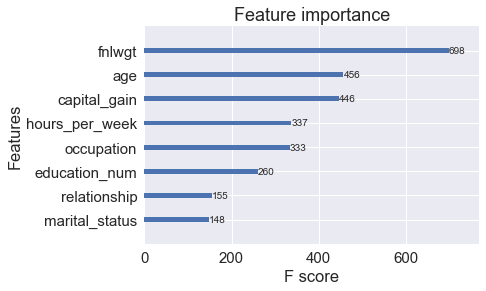

In [186]:
xgb.plot_importance(final_gb)

#### Observations
* fnlwgt shows the most important features for the income
* Age is the next important features 
* Capital Gain is the next important features 
* hours_per_week, occupation, education_num,relationship and marital_status are the next important features

---
### Problem 3: Which algorithms are best for this dataset

In [190]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

print('Predction')
print(y_pred)

print('\nAccuracy Score :', accuracy_score(y_pred, y_test_feature))
print('Error Score :', 1-accuracy_score(y_pred, y_test_feature))
print ('\Confusion Matrix')
print(confusion_matrix(y_test_feature,pred)) 
print ('\nClassification')
print(classification_report(y_test_feature,pred)) 
print('\nAbove Accuracy(85.86%) indicate here XGBOOST is the best algorithm for the datasets')

Predction
[0. 0. 0. ... 1. 0. 1.]

Accuracy Score : 0.8573705179282869
Error Score : 0.1426294820717131
\Confusion Matrix
[[10526   834]
 [ 1320  2380]]

Classification
             precision    recall  f1-score   support

          0       0.89      0.93      0.91     11360
          1       0.74      0.64      0.69      3700

avg / total       0.85      0.86      0.85     15060


Above Accuracy(85.86%) indicate here XGBOOST is the best algorithm for the datasets
